# Import Library

import library

In [1]:
import os
import cv2
import numpy as np
import segmentation_models as sm
import tensorflow as tf

from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
from tensorflow.keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K

2022-12-25 11:39:21.403063: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-25 11:39:22.831465: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/fairuzakmal/.local/lib/python3.10/site-packages/cv2/../../lib64:/usr/lib/cuda/include:/usr/lib/cuda/lib64:
2022-12-25 11:39:22.831629: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/fairuzakmal

Segmentation Models: using `keras` framework.


Cek GPU

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17316260557006090635
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4854775808
locality {
  bus_id: 1
  links {
  }
}
incarnation: 24000469108048036
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


2022-12-25 11:39:28.556269: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-25 11:39:28.626880: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-25 11:39:28.711374: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-25 11:39:28.712095: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

# Preprosesing Data

In [4]:
scaler = MinMaxScaler()
root_directory = 'dataset/'
patch_size = 512

In [5]:
for path, subdirs, files in os.walk(root_directory):
    print(path)  

dataset/
dataset/Tile 5
dataset/Tile 5/images
dataset/Tile 5/masks
dataset/Tile 6
dataset/Tile 6/images
dataset/Tile 6/masks
dataset/Tile 4
dataset/Tile 4/images
dataset/Tile 4/masks
dataset/Tile 2
dataset/Tile 2/images
dataset/Tile 2/masks
dataset/Tile 1
dataset/Tile 1/images
dataset/Tile 1/masks
dataset/Tile 3
dataset/Tile 3/images
dataset/Tile 3/masks
dataset/Tile 0
dataset/Tile 0/images
dataset/Tile 0/masks


membuat image dataset

In [7]:
images = []
masks = []
for i in range(9):
  images.append('image_{}.png'.format(i))
  masks.append('mask_{}.png'.format(i))
print(images)
print(masks)

['image_0.png', 'image_1.png', 'image_2.png', 'image_3.png', 'image_4.png', 'image_5.png', 'image_6.png', 'image_7.png', 'image_8.png']
['mask_0.png', 'mask_1.png', 'mask_2.png', 'mask_3.png', 'mask_4.png', 'mask_5.png', 'mask_6.png', 'mask_7.png', 'mask_8.png']


In [8]:
image_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':   #Find all 'images' directories
        # images = os.listdir(path)  #List of all image names in this subdirectory
        for i, image_name in enumerate(images):  
            if image_name.endswith(".png"):   #Only read jpg images...
                
                image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
                SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                image = np.array(image)             
       
                #Extract patches from each image
                print("Now patchifying image:", path+"/"+image_name)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        
                        single_patch_img = patches_img[i,j,:,:]
                        
                        #Use minmaxscaler instead of just dividing by 255. 
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. 
                        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
                        image_dataset.append(single_patch_img)

Now patchifying image: dataset/Tile 5/images/image_0.png
Now patchifying image: dataset/Tile 5/images/image_1.png
Now patchifying image: dataset/Tile 5/images/image_2.png
Now patchifying image: dataset/Tile 5/images/image_3.png
Now patchifying image: dataset/Tile 5/images/image_4.png
Now patchifying image: dataset/Tile 5/images/image_5.png
Now patchifying image: dataset/Tile 5/images/image_6.png
Now patchifying image: dataset/Tile 5/images/image_7.png
Now patchifying image: dataset/Tile 5/images/image_8.png
Now patchifying image: dataset/Tile 6/images/image_0.png
Now patchifying image: dataset/Tile 6/images/image_1.png
Now patchifying image: dataset/Tile 6/images/image_2.png
Now patchifying image: dataset/Tile 6/images/image_3.png
Now patchifying image: dataset/Tile 6/images/image_4.png
Now patchifying image: dataset/Tile 6/images/image_5.png
Now patchifying image: dataset/Tile 6/images/image_6.png
Now patchifying image: dataset/Tile 6/images/image_7.png
Now patchifying image: dataset/

membuat mask dataset

In [9]:
mask_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':   #Find all 'images' directories
        # masks = os.listdir(path)  #List of all image names in this subdirectory
        for i, mask_name in enumerate(masks):  
            if mask_name.endswith(".png"):   #Only read png images... (masks in this dataset)
               
                mask = cv2.imread(path+"/"+mask_name, 1)  #Read each image as Grey (or color but remember to map each color to an integer)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                mask = np.array(mask)             
       
                #Extract patches from each image
                print("Now patchifying mask:", path+"/"+mask_name)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        
                        single_patch_mask = patches_mask[i,j,:,:]
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                        single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.                               
                        mask_dataset.append(single_patch_mask) 

Now patchifying mask: dataset/Tile 5/masks/mask_0.png
Now patchifying mask: dataset/Tile 5/masks/mask_1.png
Now patchifying mask: dataset/Tile 5/masks/mask_2.png
Now patchifying mask: dataset/Tile 5/masks/mask_3.png
Now patchifying mask: dataset/Tile 5/masks/mask_4.png
Now patchifying mask: dataset/Tile 5/masks/mask_5.png
Now patchifying mask: dataset/Tile 5/masks/mask_6.png
Now patchifying mask: dataset/Tile 5/masks/mask_7.png
Now patchifying mask: dataset/Tile 5/masks/mask_8.png
Now patchifying mask: dataset/Tile 6/masks/mask_0.png
Now patchifying mask: dataset/Tile 6/masks/mask_1.png
Now patchifying mask: dataset/Tile 6/masks/mask_2.png
Now patchifying mask: dataset/Tile 6/masks/mask_3.png
Now patchifying mask: dataset/Tile 6/masks/mask_4.png
Now patchifying mask: dataset/Tile 6/masks/mask_5.png
Now patchifying mask: dataset/Tile 6/masks/mask_6.png
Now patchifying mask: dataset/Tile 6/masks/mask_7.png
Now patchifying mask: dataset/Tile 6/masks/mask_8.png
Now patchifying mask: datase

membuat dataset menjadi format array

In [10]:
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

cek dataset

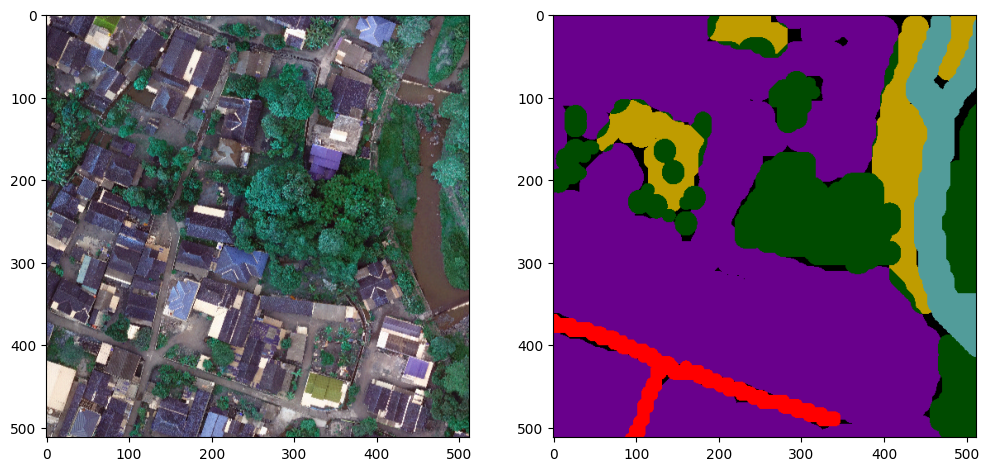

In [24]:
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()

mengubah HEX ke bentuk RGB

In [14]:
Bangunan = '#69008C'.lstrip('#')
Bangunan = np.array(tuple(int(Bangunan[i:i+2], 16) for i in (0, 2, 4))) # 105 0 140

Jalan = '#FF0000'.lstrip('#')
Jalan = np.array(tuple(int(Jalan[i:i+2], 16) for i in (0, 2, 4))) # 255 0 0

Sawah = '#00FF00'.lstrip('#') 
Sawah = np.array(tuple(int(Sawah[i:i+2], 16) for i in (0, 2, 4))) # 0 255 0

Sungai =  '529C9A'.lstrip('#') 
Sungai = np.array(tuple(int(Sungai[i:i+2], 16) for i in (0, 2, 4))) # 82 156 154

Pepohonan = '004B00'.lstrip('#') 
Pepohonan = np.array(tuple(int(Pepohonan[i:i+2], 16) for i in (0, 2, 4))) # 0 75 0

rth = '#BF9C00'.lstrip('#') 
rth = np.array(tuple(int(rth[i:i+2], 16) for i in (0, 2, 4))) # 191 156 0

label = single_patch_mask

# Labeling Dataset

membuat label untuk validasi training

In [25]:
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Bangunan,axis=-1)] = 6
    label_seg [np.all(label==Jalan,axis=-1)] = 1
    label_seg [np.all(label==Sawah,axis=-1)] = 2
    label_seg [np.all(label==Sungai,axis=-1)] = 3
    label_seg [np.all(label==Pepohonan,axis=-1)] = 4
    label_seg [np.all(label==rth,axis=-1)] = 5
    
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    
    return label_seg

In [26]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)  

In [27]:
labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)

In [28]:
print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0 1 2 3 4 5 6]


Cek label dan dataset

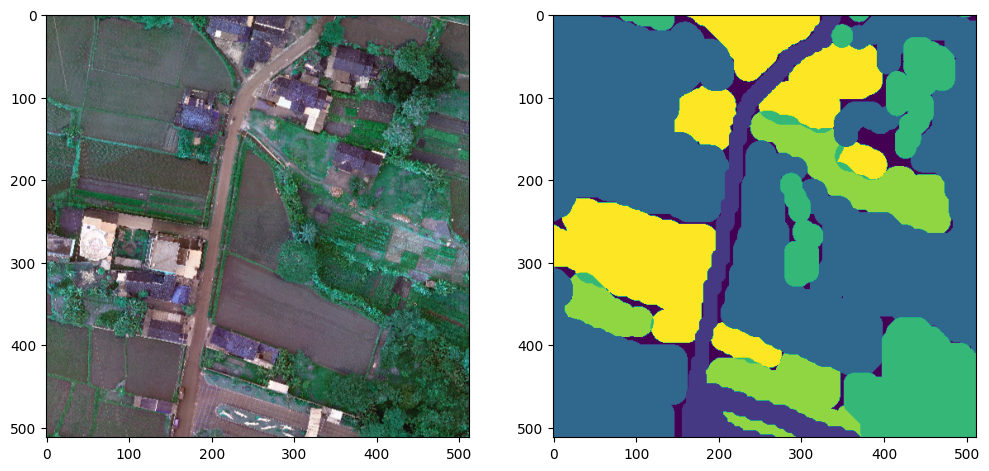

In [30]:
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

split data training dan data test

In [31]:
n_classes = len(np.unique(labels))
from tensorflow.keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)


# Membuat Model

membuat fungsi jaccard loss

In [32]:
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

membuat model learning

In [33]:
def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.summary()
    
    return model

membuat fungsi loss dengan menambahkan bobot

In [41]:
weights = [0.142, 0.142, 0.142, 0.142, 0.142, 0.142, 0.142]
dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

definisi variabel ukuran data

In [42]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

# Training

persiapan training

In [43]:
metrics=['accuracy', jacard_coef]

In [44]:
def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

In [45]:
model = get_model()
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 512, 512, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_9 (Dropout)            (None, 512, 512, 16  0           ['conv2d_19[0][0]']              
                                )                                                           

delete beberapa variabel yang tidak terpakai untuk mengurangi beban kerja

In [ ]:
del image, image_dataset, image_name, image_number, images, label, labels, labels_cat, mask, mask_dataset, mask_name, masks, patches_img, patches_mask, single_patch_img, single_patch_mask

prosesi training

In [47]:
history1 = model.fit(X_train, y_train, 
                    batch_size = 8, 
                    verbose=1, 
                    epochs=50, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Epoch 1/50


2022-12-25 11:53:52.930196: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_9/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2022-12-25 11:53:54.427717: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8600
2022-12-25 11:53:55.180250: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-25 11:53:55.181591: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-25 11:53:55.181609: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:85] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-12-25 11:53:55.182275: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-25 11:53:55.182

InternalError: Graph execution error:

Detected at node 'StatefulPartitionedCall_45' defined at (most recent call last):
    File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/home/fairuzakmal/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/fairuzakmal/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 985, in launch_instance
      app.start()
    File "/home/fairuzakmal/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/fairuzakmal/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 600, in run_forever
      self._run_once()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 1896, in _run_once
      handle._run()
    File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/fairuzakmal/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/fairuzakmal/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/fairuzakmal/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/fairuzakmal/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/home/fairuzakmal/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/home/fairuzakmal/.local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/fairuzakmal/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "/home/fairuzakmal/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "/home/fairuzakmal/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/fairuzakmal/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/fairuzakmal/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/fairuzakmal/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_15439/1494727085.py", line 1, in <module>
      history1 = model.fit(X_train, y_train,
    File "/home/fairuzakmal/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/fairuzakmal/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/fairuzakmal/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/home/fairuzakmal/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/fairuzakmal/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/home/fairuzakmal/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/home/fairuzakmal/.local/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/home/fairuzakmal/.local/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/home/fairuzakmal/.local/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/home/fairuzakmal/.local/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/home/fairuzakmal/.local/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/home/fairuzakmal/.local/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_45'
libdevice not found at ./libdevice.10.bc
	 [[{{node StatefulPartitionedCall_45}}]] [Op:__inference_train_function_6990]

# Tes dan Evaluasi

In [26]:
history = history1
acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']
loss = history.history['loss']
val_loss = history.history['val_loss']

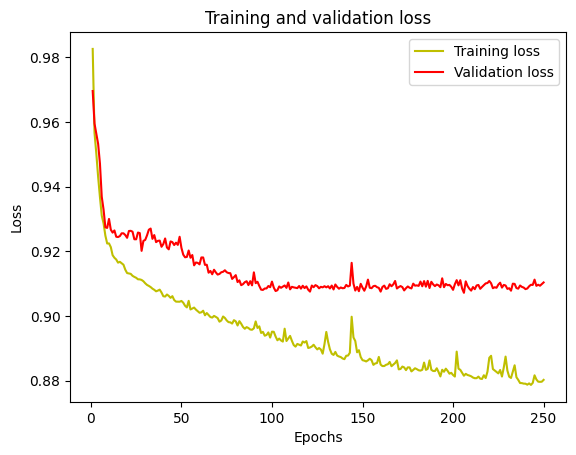

In [27]:
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

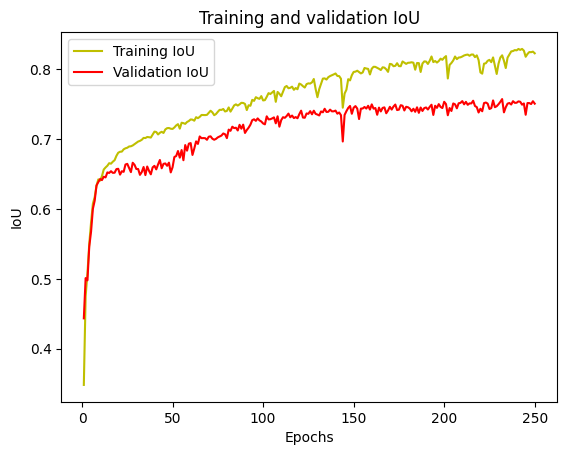

In [28]:
plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [29]:
#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

9/9 [==============================] - 3s 68ms/step


In [30]:
#Using built in keras function for IoU
from keras.metrics import MeanIoU
n_classes = 6
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.61273503


tes pada beberapa data

1/1 [==============================] - 0s 27ms/step


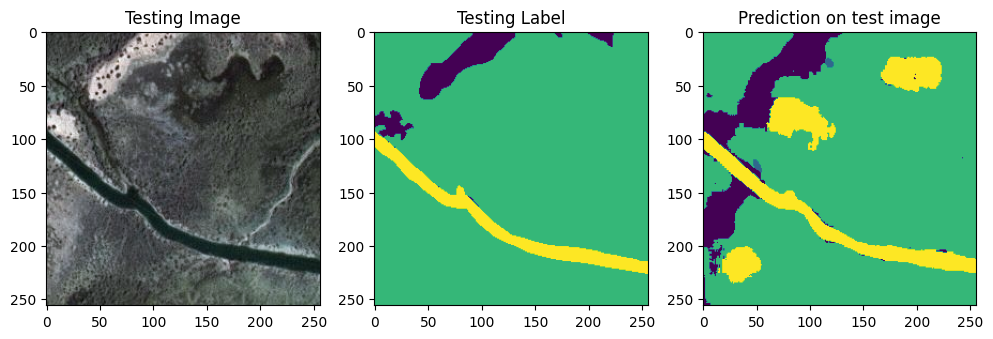

In [37]:
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

# Save Model

In [50]:
model.save('D:\latihan\semantic_segmentation\model001.hdf5')

# Load dan Uji Model

In [58]:
model_0 = keras.models.load_model('model001.hdf5', custom_objects={
    'dice_loss_plus_1focal_loss': total_loss, 
    'jacard_coef':jacard_coef
    })

1/1 [==============================] - 0s 27ms/step


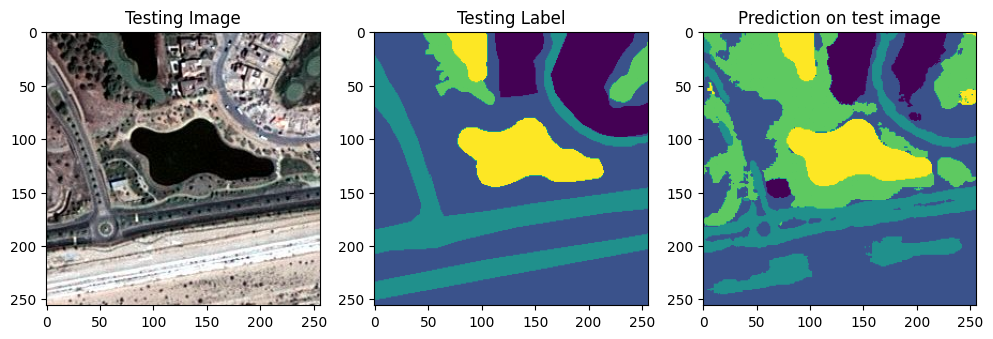

In [60]:
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model_0.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()